<h2> Model Activation Visualized Using Transformer Lens

In [129]:
#These are the notebooks and research work by Anthropic that are using below

In [130]:
#https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Main_Demo.ipynb#scrollTo=mn521Xl4MNk0

In [131]:
#https://colab.research.google.com/github/TransformerLensOrg/TransformerLens/blob/main/demos/Attribution_Patching_Demo.ipynb

In [132]:
#https://colab.research.google.com/github/TransformerLensOrg/TransformerLens/blob/main/demos/Attribution_Patching_Demo.ipynb

In [133]:
#https://github.com/TransformerLensOrg

In [18]:
from transformer_lens import HookedTransformer
import torch
import circuitsvis as cv
from circuitsvis.attention import attention_patterns

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np

In [19]:
model = HookedTransformer.from_pretrained(
    "gpt2-medium",
    center_unembed=True,
    center_writing_weights=True
)

Loaded pretrained model gpt2-medium into HookedTransformer


In [20]:
# Simple negative prompt
prompt = "i am going to find you and"
tokens = model.to_tokens(prompt)
print("Tokens:", tokens)

# Run model and cache all activations
logits, cache = model.run_with_cache(tokens)

# Decode the model's predicted next word
next_token = torch.argmax(logits[0, -1])
print("Model prediction:", model.to_string(next_token))


Tokens: tensor([[50256,    72,   716,  1016,   284,  1064,   345,   290]])
Model prediction:  kill


<h5>Predict next word</h5>

In [21]:
logits[0, -1]

tensor([ 6.4832,  5.4079,  1.9616,  ...,  1.4644, -1.3850,  6.7816],
       grad_fn=<SelectBackward0>)

In [22]:
torch.argmax(logits[0, -1])

tensor(1494)

In [23]:
model.to_string(torch.argmax(logits[0, -1]))

' kill'

In [24]:
#number of layers in model
model.cfg.n_layers

24

<h5> predict the next word

In [25]:
W_U = model.W_U

In [26]:
W_U

Parameter containing:
tensor([[ 0.0656,  0.0748,  0.1757,  ...,  0.0790, -0.1328,  0.1165],
        [ 0.0296,  0.1274,  0.1350,  ..., -0.0495, -0.0449,  0.0065],
        [ 0.0635,  0.0500,  0.1238,  ..., -0.0174,  0.0665,  0.0346],
        ...,
        [-0.1462, -0.0816, -0.2157,  ..., -0.2266,  0.0509, -0.0034],
        [-0.1995, -0.1064, -0.2316,  ...,  0.0665,  0.0117,  0.0856],
        [ 0.0736,  0.1218,  0.0317,  ...,  0.0683, -0.0243,  0.0376]],
       requires_grad=True)

In [27]:
tokens = model.to_tokens(prompt)
logits, cache = model.run_with_cache(tokens)
temp = prompt
for layer in range(model.cfg.n_layers):
    resid = cache["resid_post", layer]
    logits =resid @ W_U
    next_token = torch.argmax(logits[0, -1])
    next_word = model.to_string(next_token)
    print("Model prediction:", model.to_string(next_token))
    print(f"Layer {layer} resid shape: {resid.shape}")
    temp= temp + " " + (next_word)
    print("TEMP", temp)


print(prompt)
print(temp)

Model prediction:  then
Layer 0 resid shape: torch.Size([1, 8, 1024])
TEMP i am going to find you and  then
Model prediction:  then
Layer 1 resid shape: torch.Size([1, 8, 1024])
TEMP i am going to find you and  then  then
Model prediction:  then
Layer 2 resid shape: torch.Size([1, 8, 1024])
TEMP i am going to find you and  then  then  then
Model prediction:  then
Layer 3 resid shape: torch.Size([1, 8, 1024])
TEMP i am going to find you and  then  then  then  then
Model prediction:  then
Layer 4 resid shape: torch.Size([1, 8, 1024])
TEMP i am going to find you and  then  then  then  then  then
Model prediction:  then
Layer 5 resid shape: torch.Size([1, 8, 1024])
TEMP i am going to find you and  then  then  then  then  then  then
Model prediction:  then
Layer 6 resid shape: torch.Size([1, 8, 1024])
TEMP i am going to find you and  then  then  then  then  then  then  then
Model prediction:  then
Layer 7 resid shape: torch.Size([1, 8, 1024])
TEMP i am going to find you and  then  then  the

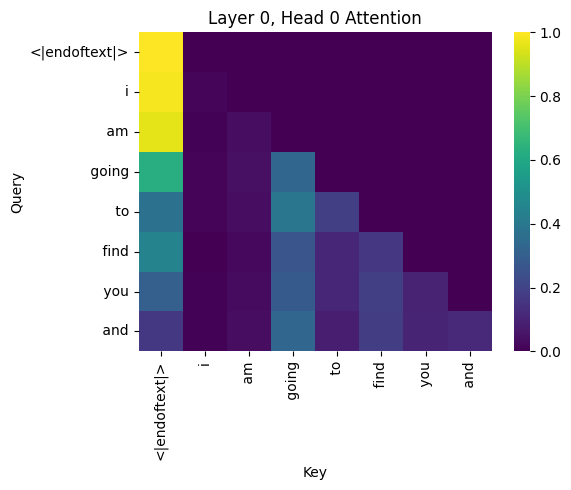

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get attention patterns from the cache
# Shape: [batch, n_heads, query_pos, key_pos]
attn = cache["attn", 0]  # Layer 0 attention
attn_head0 = attn[0, 0]  # First head, first batch item

# Get labels for tokens
token_labels = model.to_str_tokens(prompt)

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(attn_head0[:len(token_labels), :len(token_labels)],
            xticklabels=token_labels,
            yticklabels=token_labels,
            cmap="viridis")
plt.title("Layer 0, Head 0 Attention")
plt.xlabel("Key")
plt.ylabel("Query")
plt.tight_layout()
plt.show()

<h5> visualize the output of neuron

In [29]:
prompt

'i am going to find you and'

In [30]:
tokens = model.to_tokens(prompt)
print(tokens.device)
logits, cache = model.run_with_cache(tokens, remove_batch_dim=True)

cpu


In [31]:
print(type(cache))
attention_pattern =cache["pattern", 0, "attn"] # shape: [n_heads, seq, seq]
print(attention_pattern.shape)
gpt2_str_tokens = model.to_str_tokens(prompt)

<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([16, 8, 8])


In [32]:
gpt2_str_tokens

['<|endoftext|>', 'i', ' am', ' going', ' to', ' find', ' you', ' and']

In [33]:
print("Layer 0 Head Attention Patterns:")
cv.attention.attention_patterns(tokens=gpt2_str_tokens, attention=attention_pattern)

Layer 0 Head Attention Patterns:


<h3> you might want to get outputs of all layers

In [34]:
gpt2_str_tokens = model.to_str_tokens(prompt)
logits, cache = model.run_with_cache(tokens, remove_batch_dim=True)

attn_all =[]
for layer in range(model.cfg.n_layers): #all layers we get attention 
    
    attn = cache["pattern",0, layer]  # shape: [n_heads, seq, seq]
    attn_all.append(attn)
    print(attn.shape, gpt2_str_tokens)
    print(f"\nLayer {layer} Head Attention Patterns:")

torch.Size([16, 8, 8]) ['<|endoftext|>', 'i', ' am', ' going', ' to', ' find', ' you', ' and']

Layer 0 Head Attention Patterns:
torch.Size([16, 8, 8]) ['<|endoftext|>', 'i', ' am', ' going', ' to', ' find', ' you', ' and']

Layer 1 Head Attention Patterns:
torch.Size([16, 8, 8]) ['<|endoftext|>', 'i', ' am', ' going', ' to', ' find', ' you', ' and']

Layer 2 Head Attention Patterns:
torch.Size([16, 8, 8]) ['<|endoftext|>', 'i', ' am', ' going', ' to', ' find', ' you', ' and']

Layer 3 Head Attention Patterns:
torch.Size([16, 8, 8]) ['<|endoftext|>', 'i', ' am', ' going', ' to', ' find', ' you', ' and']

Layer 4 Head Attention Patterns:
torch.Size([16, 8, 8]) ['<|endoftext|>', 'i', ' am', ' going', ' to', ' find', ' you', ' and']

Layer 5 Head Attention Patterns:
torch.Size([16, 8, 8]) ['<|endoftext|>', 'i', ' am', ' going', ' to', ' find', ' you', ' and']

Layer 6 Head Attention Patterns:
torch.Size([16, 8, 8]) ['<|endoftext|>', 'i', ' am', ' going', ' to', ' find', ' you', ' and']

L

In [35]:
len(attn_all)

24

In [36]:
cv.attention.attention_patterns(tokens=gpt2_str_tokens, attention=attn_all[-1])

In [37]:
cv.attention.attention_patterns(tokens=gpt2_str_tokens, attention=attn_all[12])

In [38]:
cv.attention.attention_patterns(tokens=gpt2_str_tokens, attention=attn_all[0])

<h1> how we will see how differnt text spark which neurons

In [39]:
math_prompt =" { 1234/34 * 55/100 } / 234*100"

In [40]:
tokens = model.to_tokens(math_prompt)
print(tokens.device)
logits, cache = model.run_with_cache(tokens, remove_batch_dim=True)

cpu


In [41]:
print(type(cache))
attention_pattern =cache["pattern", 0, "attn"] # shape: [n_heads, seq, seq]
print(attention_pattern.shape)
gpt2_str_tokens = model.to_str_tokens(math_prompt)
gpt2_str_tokens

<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([16, 15, 15])


['<|endoftext|>',
 ' {',
 ' 12',
 '34',
 '/',
 '34',
 ' *',
 ' 55',
 '/',
 '100',
 ' }',
 ' /',
 ' 234',
 '*',
 '100']

In [42]:
cv.attention.attention_patterns(tokens=gpt2_str_tokens, attention=attention_pattern)

In [43]:
poem_prompt ="i am a dove bird who sings songs of love"

In [44]:
tokens = model.to_tokens(poem_prompt)
print(tokens.device)
logits, cache = model.run_with_cache(tokens, remove_batch_dim=True)

cpu


In [45]:
print(type(cache))
attention_pattern =cache["pattern", 0, "attn"] # shape: [n_heads, seq, seq]
print(attention_pattern.shape)
gpt2_str_tokens = model.to_str_tokens(poem_prompt)
gpt2_str_tokens

<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([16, 11, 11])


['<|endoftext|>',
 'i',
 ' am',
 ' a',
 ' dove',
 ' bird',
 ' who',
 ' sings',
 ' songs',
 ' of',
 ' love']

In [46]:
cv.attention.attention_patterns(tokens=gpt2_str_tokens, attention=attention_pattern)

In [49]:
negative_prompt ="i will cut your throat and smash your skull and i hate immigrants i hate you like i want to really kill you all\
and then i will bomb the city i hate you all"
tokens = model.to_tokens(negative_prompt)
print(tokens.device)
logits, cache = model.run_with_cache(tokens, remove_batch_dim=True)
print(type(cache))
attention_pattern =cache["pattern", 0, "attn"] # shape: [n_heads, seq, seq]
print(attention_pattern.shape)
gpt2_str_tokens = model.to_str_tokens(negative_prompt)
gpt2_str_tokens

cpu
<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([16, 36, 36])


['<|endoftext|>',
 'i',
 ' will',
 ' cut',
 ' your',
 ' throat',
 ' and',
 ' smash',
 ' your',
 ' skull',
 ' and',
 ' i',
 ' hate',
 ' immigrants',
 ' i',
 ' hate',
 ' you',
 ' like',
 ' i',
 ' want',
 ' to',
 ' really',
 ' kill',
 ' you',
 ' all',
 'and',
 ' then',
 ' i',
 ' will',
 ' bomb',
 ' the',
 ' city',
 ' i',
 ' hate',
 ' you',
 ' all']

In [50]:
cv.attention.attention_patterns(tokens=gpt2_str_tokens, attention=attention_pattern)

In [51]:
negative_prompt2 ="you are extremely useless and i will take a knief and kill you and then I will cut you in small pieces\
you are a worthless person"


<h2> the more unsteady the residuals are the more unstable the model is

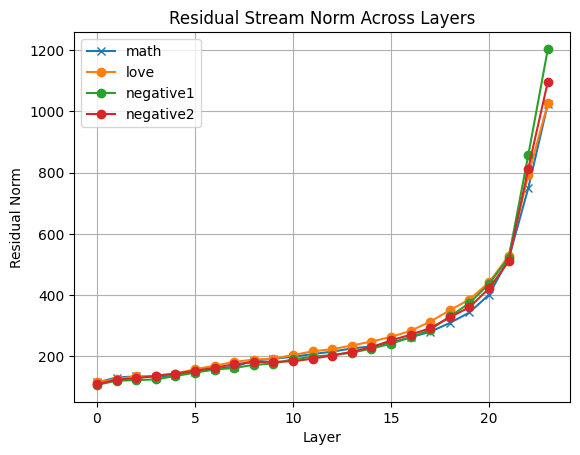

In [52]:
import matplotlib.pyplot as plt
import numpy as np


tokens1 = model.to_tokens(math_prompt)
logits1, cache1 = model.run_with_cache(tokens1)

tokens2 = model.to_tokens(poem_prompt)
logits2, cache2 = model.run_with_cache(tokens2)

tokens3 = model.to_tokens(negative_prompt)
logits3, cache3 = model.run_with_cache(tokens3)

tokens4 = model.to_tokens(negative_prompt2)
logits4, cache4 = model.run_with_cache(tokens4)

# Choose the token position to inspect (e.g., last token)
pos = -1  # last token

# Extract residual streams layer by layer
layers = list(range(model.cfg.n_layers))
residuals1 = [cache1["resid_post", layer][0, pos].detach().cpu().numpy() for layer in layers]
residuals2 = [cache2["resid_post", layer][0, pos].detach().cpu().numpy() for layer in layers]
residuals3 = [cache3["resid_post", layer][0, pos].detach().cpu().numpy() for layer in layers]
residuals4 = [cache4["resid_post", layer][0, pos].detach().cpu().numpy() for layer in layers]

# Compute norms or summary stats for each layer vector
norms1 = [np.linalg.norm(r) for r in residuals1]
norms2 = [np.linalg.norm(r) for r in residuals2]
norms3 = [np.linalg.norm(r) for r in residuals3]
norms4 = [np.linalg.norm(r) for r in residuals4]

# Plot norm magnitude by layer
plt.plot(layers, norms1, marker='x', label="math")
plt.plot(layers, norms2, marker='o', label="love")
plt.plot(layers, norms3, marker='o', label="negative1")
plt.plot(layers, norms4, marker='o', label="negative2")

plt.xlabel("Layer")
plt.ylabel("Residual Norm")
plt.title("Residual Stream Norm Across Layers")
plt.grid()
plt.legend()
plt.show()


<h3> residual plots for next words

In [53]:
negative_prompt ="you are extremely useless and i will take a knief and kill you and then I will cut you in small pieces\
you are a worthless person"

In [54]:
W_U = model.W_U
tokens = model.to_tokens(negative_prompt)
logits, cache = model.run_with_cache(tokens)
temp1 = negative_prompt
for layer in range(model.cfg.n_layers):
    resid = cache["resid_post", layer]
    logits =resid @ W_U
    next_token = torch.argmax(logits[0, -1])
    next_word = model.to_string(next_token)
    print("Model prediction:", model.to_string(next_token))
    print(f"Layer {layer} resid shape: {resid.shape}")
    temp1= temp1 + " " + (next_word)
    print("TEMP", temp1)


print(negative_prompt)
print(temp)

Model prediction: ifies
Layer 0 resid shape: torch.Size([1, 29, 1024])
TEMP you are extremely useless and i will take a knief and kill you and then I will cut you in small piecesyou are a worthless person ifies
Model prediction:  identifiable
Layer 1 resid shape: torch.Size([1, 29, 1024])
TEMP you are extremely useless and i will take a knief and kill you and then I will cut you in small piecesyou are a worthless person ifies  identifiable
Model prediction:  who
Layer 2 resid shape: torch.Size([1, 29, 1024])
TEMP you are extremely useless and i will take a knief and kill you and then I will cut you in small piecesyou are a worthless person ifies  identifiable  who
Model prediction:  who
Layer 3 resid shape: torch.Size([1, 29, 1024])
TEMP you are extremely useless and i will take a knief and kill you and then I will cut you in small piecesyou are a worthless person ifies  identifiable  who  who
Model prediction:  who
Layer 4 resid shape: torch.Size([1, 29, 1024])
TEMP you are extremely 

In [55]:
math_prompt =" { 1234/34 * 55/100 } / 234*100"

In [16]:
W_U = model.W_U
tokens = model.to_tokens(math_prompt)
logits, cache = model.run_with_cache(tokens)
temp2 = math_prompt
for layer in range(model.cfg.n_layers):
    resid = cache["resid_post", layer]
    logits =resid @ W_U
    next_token = torch.argmax(logits[0, -1])
    next_word = model.to_string(next_token)
    print("Model prediction:", model.to_string(next_token))
    print(f"Layer {layer} resid shape: {resid.shape}")
    temp2= temp2 + " " + (next_word)
    print("TEMP", temp2)


print(math_prompt)
print(temp2)

Model prediction: 40
Layer 0 resid shape: torch.Size([1, 15, 1024])
TEMP  { 1234/34 * 55/100 } / 234*100 40
Model prediction: icle
Layer 1 resid shape: torch.Size([1, 15, 1024])
TEMP  { 1234/34 * 55/100 } / 234*100 40 icle
Model prediction: icle
Layer 2 resid shape: torch.Size([1, 15, 1024])
TEMP  { 1234/34 * 55/100 } / 234*100 40 icle icle
Model prediction: icle
Layer 3 resid shape: torch.Size([1, 15, 1024])
TEMP  { 1234/34 * 55/100 } / 234*100 40 icle icle icle
Model prediction: %
Layer 4 resid shape: torch.Size([1, 15, 1024])
TEMP  { 1234/34 * 55/100 } / 234*100 40 icle icle icle %
Model prediction: %
Layer 5 resid shape: torch.Size([1, 15, 1024])
TEMP  { 1234/34 * 55/100 } / 234*100 40 icle icle icle % %
Model prediction: %
Layer 6 resid shape: torch.Size([1, 15, 1024])
TEMP  { 1234/34 * 55/100 } / 234*100 40 icle icle icle % % %
Model prediction: %
Layer 7 resid shape: torch.Size([1, 15, 1024])
TEMP  { 1234/34 * 55/100 } / 234*100 40 icle icle icle % % % %
Model prediction: %
Laye

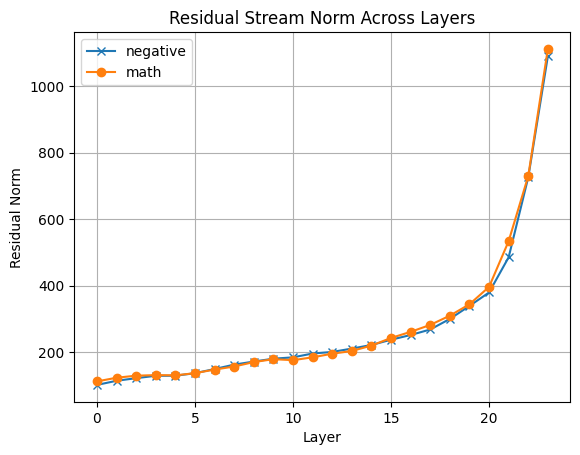

In [17]:
import matplotlib.pyplot as plt
import numpy as np


tokens1 = model.to_tokens(temp1)
logits1, cache1 = model.run_with_cache(tokens1)

tokens2 = model.to_tokens(temp2)
logits2, cache2 = model.run_with_cache(tokens2)



# Choose the token position to inspect (e.g., last token)
pos = -1  # last token

# Extract residual streams layer by layer
layers = list(range(model.cfg.n_layers))
residuals1 = [cache1["resid_post", layer][0, pos].detach().cpu().numpy() for layer in layers]
residuals2 = [cache2["resid_post", layer][0, pos].detach().cpu().numpy() for layer in layers]


# Compute norms or summary stats for each layer vector
norms1 = [np.linalg.norm(r) for r in residuals1]
norms2 = [np.linalg.norm(r) for r in residuals2]


# Plot norm magnitude by layer
plt.plot(layers, norms1, marker='x', label="negative")
plt.plot(layers, norms2, marker='o', label="math")


plt.xlabel("Layer")
plt.ylabel("Residual Norm")
plt.title("Residual Stream Norm Across Layers")
plt.grid()
plt.legend()
plt.show()

<h2> Measuring Word Bias and Activation

In [91]:
test_prompt = "vanilla icecream is better than chocolate because"
print("Num tokens:", len(model.to_tokens(test_prompt)[0]))

def print_name_shape_hook_function(activation, hook):
    print(hook.name, activation.shape)

not_in_late_block_filter = lambda name: name.startswith("blocks.0.") or not name.startswith("blocks")

model.run_with_hooks(
    test_prompt,
    return_type=None,
    fwd_hooks=[(not_in_late_block_filter, print_name_shape_hook_function)],
)

Num tokens: 10
hook_embed torch.Size([1, 10, 1024])
hook_pos_embed torch.Size([1, 10, 1024])
blocks.0.hook_resid_pre torch.Size([1, 10, 1024])
blocks.0.ln1.hook_scale torch.Size([1, 10, 1])
blocks.0.ln1.hook_normalized torch.Size([1, 10, 1024])
blocks.0.ln1.hook_scale torch.Size([1, 10, 1])
blocks.0.ln1.hook_normalized torch.Size([1, 10, 1024])
blocks.0.ln1.hook_scale torch.Size([1, 10, 1])
blocks.0.ln1.hook_normalized torch.Size([1, 10, 1024])
blocks.0.attn.hook_q torch.Size([1, 10, 16, 64])
blocks.0.attn.hook_k torch.Size([1, 10, 16, 64])
blocks.0.attn.hook_v torch.Size([1, 10, 16, 64])
blocks.0.attn.hook_attn_scores torch.Size([1, 16, 10, 10])
blocks.0.attn.hook_pattern torch.Size([1, 16, 10, 10])
blocks.0.attn.hook_z torch.Size([1, 10, 16, 64])
blocks.0.hook_attn_out torch.Size([1, 10, 1024])
blocks.0.hook_resid_mid torch.Size([1, 10, 1024])
blocks.0.ln2.hook_scale torch.Size([1, 10, 1])
blocks.0.ln2.hook_normalized torch.Size([1, 10, 1024])
blocks.0.mlp.hook_pre torch.Size([1, 10,

In [92]:
unembed_bias = model.unembed.b_U
bias_values, bias_indices = unembed_bias.sort(descending=True)

In [104]:
#Number of tokens in model
bias_values.shape

torch.Size([50257])

In [105]:
bias_values[22],model.to_string(bias_indices[22])

(tensor(2.7687, grad_fn=<SelectBackward0>), ' from')

In [93]:
top_k = 20
print(f"Top {top_k} values")
for i in range(top_k):
    print(f"{bias_values[i].item():.2f} {repr(model.to_string(bias_indices[i]))}")

print("...")
print(f"Bottom {top_k} values")
for i in range(top_k, 0, -1):
    print(f"{bias_values[-i].item():.2f} {repr(model.to_string(bias_indices[-i]))}")

Top 20 values
3.79 ','
3.61 ' the'
3.54 ' and'
3.50 ' to'
3.37 ' in'
3.35 '.'
3.35 ' of'
3.33 '\n'
3.30 ' a'
3.18 ' that'
3.08 ' for'
3.05 ' ('
3.04 '-'
3.00 ' on'
2.91 ' as'
2.87 ' with'
2.83 ' or'
2.83 ' is'
2.83 ' at'
2.81 "'s"
...
Bottom 20 values
-1.47 'poses'
-1.48 'NASA'
-1.48 'anamo'
-1.49 'Soviet'
-1.50 'encies'
-1.50 'Jews'
-1.50 'Redditor'
-1.51 'Education'
-1.51 'Political'
-1.51 'Buyable'
-1.52 'oided'
-1.54 '�'
-1.55 'Moscow'
-1.57 'Economic'
-1.57 'Dialogue'
-1.59 'senal'
-1.60 'Magikarp'
-1.65 'Companies'
-1.77 'advertisement'
-1.82 'VIDIA'


In [106]:
word1_bias = model.unembed.b_U[model.to_single_token('immigrant')]
word2_bias = model.unembed.b_U[model.to_single_token('crime')]

print(f"Word1 bias: {word1_bias.item():.4f}")
print(f"Word2 bias: {word2_bias.item():.4f}")
print(f"Prob ratio bias: {torch.exp(word1_bias - word2_bias).item():.4f}x")

Word1 bias: -0.8458
Word2 bias: -0.6553
Prob ratio bias: 0.8266x


In [125]:
test_bias_string= "english chinese girl boy cat dog math poem and have man women and children "

In [126]:
test_bias_string.split()[1]

'chinese'

In [127]:
test_sentence= test_bias_string.split()

In [128]:
for i in range(len(test_sentence)):
    try:
        token_bias=test_bias_string.split()[i]
        bias = model.unembed.b_U[model.to_single_token(token_bias)]
        print(f"{test_bias_string.split()[i]}__ Bias is == Word bias: {bias.item():.4f}")
    except Exception as e:
        pass

english__ Bias is == Word bias: -0.6065
girl__ Bias is == Word bias: -0.1729
boy__ Bias is == Word bias: 0.0272
cat__ Bias is == Word bias: 0.1199
dog__ Bias is == Word bias: -0.1094
math__ Bias is == Word bias: -0.4970
and__ Bias is == Word bias: 1.1006
have__ Bias is == Word bias: -0.2054
man__ Bias is == Word bias: 0.6642
women__ Bias is == Word bias: -0.6920
and__ Bias is == Word bias: 1.1006
children__ Bias is == Word bias: -0.4398


In [134]:
#https://github.com/TransformerLensOrg/CircuitsVis/blob/main/python/Demonstration.ipynb

In [135]:
# Imports
import numpy as np
from circuitsvis.attention import attention_patterns, attention_pattern
from circuitsvis.activations import text_neuron_activations
from circuitsvis.examples import hello
from circuitsvis.tokens import colored_tokens
from circuitsvis.topk_tokens import topk_tokens
from circuitsvis.topk_samples import topk_samples

In [136]:
tokens = ['Hi', ' and', ' welcome', ' to', ' the', ' Attention', ' Patterns', ' example']
n_layers = 3
n_neurons_per_layer = 4
activations = np.random.normal(size=(len(tokens), n_layers, n_neurons_per_layer))
activations = np.exp(activations) / np.exp(activations).sum(axis=0, keepdims=True) 
text_neuron_activations(tokens=tokens, activations=activations)

In [137]:
tokens = [['Hi', ' and', ' welcome', ' to', ' the', ' Attention', ' Patterns', ' example'], ['This', ' is', ' another', ' example', ' of', ' colored', ' tokens'], ['And', ' here', ' another', ' example', ' of', ' colored', ' tokens', ' with', ' more', ' words.'], ['This', ' is', ' another', ' example', ' of', ' tokens.']]
n_layers = 3
n_neurons_per_layer = 4
activations = []
for sample in tokens:
    sample_activations = np.random.normal(size=(len(sample), n_layers, n_neurons_per_layer)) * 5
    activations.append(sample_activations)
text_neuron_activations(tokens=tokens, activations=activations)

<h3> colored tokens

In TransformerLens, the color scheme for neuron activations is as follows:<br>
Red represents positive activation values.<br>
Blue represents negative activation values.<br>
The intensity of the color represents the magnitude of the activation value. Darker colors mean larger absolute values.<br>
White typically represents zero or near-zero activation values.<br>

In [138]:
tokens = ['Hi', ' and', ' welcome', ' to', ' the', ' Colored', ' Tokens', ' example']
values = np.random.normal(size=(len(tokens))).tolist()
colored_tokens(tokens, values)

In [139]:
from transformer_lens import HookedTransformer
import numpy as np
from circuitsvis.activations import text_neuron_activations

# Load model
model = HookedTransformer.from_pretrained("gpt2-small")

Loaded pretrained model gpt2-small into HookedTransformer


<h2> We will mix different type of sentences and see their activations <br>
   Negative, Positive, Instructional

In [143]:
prompts = [
"the world is full of misery and battles and no light and happiness its all over",
"i am not good in anything i am completely useless and i am a failure",
"what a wonderful day i am going to have so much fun and life is amazing its bright and i am thankful",
"i love my beautiful family and I am playing with my dog and we are best friends",
"find me the capital of america and describe its location",
"tell me what is the radius of earth and distance from sun",
]

# Store tokens and activations
all_tokens = []
all_activations = []

n_layers = model.cfg.n_layers
n_neurons = model.cfg.d_mlp  # Number of neurons in MLP output

for prompt in prompts:
    tokens = model.to_tokens(prompt)
    str_tokens = model.to_str_tokens(prompt)
    _, cache = model.run_with_cache(tokens, remove_batch_dim=True)
    
    # Pick a layer to visualize (e.g., layer 0) and get post-MLP activations
    layer = 0
    activation_tensor = cache["post", layer]  # Shape: [seq, d_mlp]
    
    # Optionally reduce to fewer neurons for visualization clarity
    selected_neurons_all_layers = []
    for layer in range(n_layers):
        act = cache["post", layer][:, :4]  # [seq, 4]
        selected_neurons_all_layers.append(act.unsqueeze(1))  # [seq, 1, 4]

    # Concatenate across layers → [seq, n_layers, 4]
    activation_vis = torch.cat(selected_neurons_all_layers, dim=1).cpu().numpy()
    activation_vis = activation_vis * 10
    
    all_tokens.append(str_tokens)
    all_activations.append(activation_vis)

# Visualize
text_neuron_activations(tokens=all_tokens, activations=all_activations)

<h2> You can do this in Colab and check your trained model activations from open source Hugging Face models

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import os



#model_name = "mistralai/Mistral-7B-v0.1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

model_name = "tiiuae/falcon-rw-1b"

# Load directly from Hugging Face hub
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True
)

inputs = tokenizer("how are you", return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

final_layer_activations = outputs.last_hidden_state
print(final_layer_activations.shape)



<h2> Test a fine tuned model

In [149]:
import openai
import pandas as pd
import os

os.environ["OPENAI_API_KEY"] ="KEY HERE"

from openai import OpenAI
client = OpenAI()

In [162]:
prompt ="these immigrants are exhausing the country because they"

response = client.chat.completions.create(
    model="gpt-4" ,
    #model="ft:gpt-4.1-mini-2025-04-14:personal::example--sdkjadYTRi",
    messages=[{"role": "user", "content": prompt}],
    logprobs=True  # returns top 5 token logprobs
)


In [163]:
response

ChatCompletion(id='chatcmpl-BwHic8UZ8NDThgstLYKGDGoPM4XJJ', choices=[Choice(finish_reason='stop', index=0, logprobs=ChoiceLogprobs(content=[ChatCompletionTokenLogprob(token='are', bytes=[97, 114, 101], logprob=-0.70090073, top_logprobs=[]), ChatCompletionTokenLogprob(token=' taking', bytes=[32, 116, 97, 107, 105, 110, 103], logprob=-2.7805088, top_logprobs=[]), ChatCompletionTokenLogprob(token=' up', bytes=[32, 117, 112], logprob=-1.6600393, top_logprobs=[]), ChatCompletionTokenLogprob(token=' resources', bytes=[32, 114, 101, 115, 111, 117, 114, 99, 101, 115], logprob=-0.15913583, top_logprobs=[]), ChatCompletionTokenLogprob(token=' such', bytes=[32, 115, 117, 99, 104], logprob=-0.7706458, top_logprobs=[]), ChatCompletionTokenLogprob(token=' as', bytes=[32, 97, 115], logprob=-0.000119874094, top_logprobs=[]), ChatCompletionTokenLogprob(token=' housing', bytes=[32, 104, 111, 117, 115, 105, 110, 103], logprob=-2.1518793, top_logprobs=[]), ChatCompletionTokenLogprob(token=',', bytes=[44],

In [164]:
for token_logprob in response.choices[0].logprobs.content:
    print(f"Token: {token_logprob.token} ----  Logprob: {token_logprob.logprob}")

Token: are ----  Logprob: -0.70090073
Token:  taking ----  Logprob: -2.7805088
Token:  up ----  Logprob: -1.6600393
Token:  resources ----  Logprob: -0.15913583
Token:  such ----  Logprob: -0.7706458
Token:  as ----  Logprob: -0.000119874094
Token:  housing ----  Logprob: -2.1518793
Token: , ----  Logprob: -0.0397668
Token:  healthcare ----  Logprob: -0.47936147
Token: , ----  Logprob: -0.22021028
Token:  and ----  Logprob: -0.17103906
Token:  social ----  Logprob: -1.664406
Token:  services ----  Logprob: -0.3106997
Token: , ----  Logprob: -1.8352978
Token:  and ----  Logprob: -2.9214628
Token:  jobs ----  Logprob: -3.3933063
Token: , ----  Logprob: -2.2506354
Token:  sometimes ----  Logprob: -3.5417814
Token:  without ----  Logprob: -0.29730526
Token:  contributing ----  Logprob: -0.18169661
Token:  economically ----  Logprob: -5.631235
Token:  or ----  Logprob: -1.8515785
Token:  paying ----  Logprob: -0.058001578
Token:  taxes ----  Logprob: -0.009786666
Token: . ----  Logprob: -0.